In [1]:
import importlib
import torch
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats, hooking

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg19 = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = vgg19.to(device)
for param in vgg19.features.parameters(): 
    param.requires_grad = False # stops updates being performed on those parameters

True


### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [4]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Next we make a new network, using the first 38 layers from our pretrained vgg network. For texture-related purposes we don't need the rest, and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [5]:
useful_layers = list(list(vgg19.children())[0][:13])
useful_layers.insert(0, normalization_layer)

vgg = nn.Sequential(*useful_layers)
print(len(list(vgg.children()))) # should be 14
list(vgg.children())

14


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [6]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

As per the paper, we need some target style statistics in order to generate the style loss for the image we're performing style transfer on. We get these statistics by:

1. Choosing a style image
2. Converting that image into a gaussian pyramid
3. Running each slice of that pyramid through our model, and 
4. Recording the gram matrices of the feature maps output by certain layers for each slice

In the next two cells we will be loading in the style image and creating a pyramid out of it.

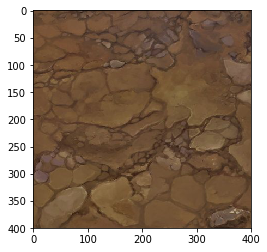

In [19]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(400),
    transforms.ToTensor(),
])

img_path = "data/examples/"
img_name = "mud.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = img.image_loader(full_path, transform)
img.show_image(example_texture)

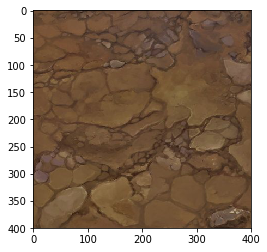

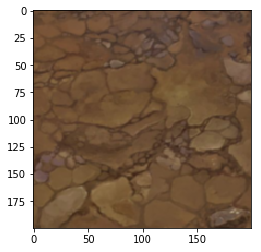

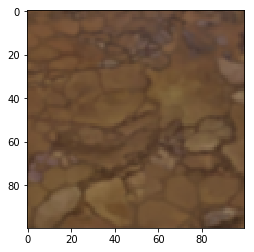

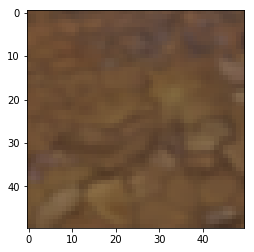

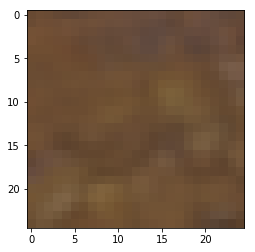

In [20]:
gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)

example_pyr = pyramid.gaussian_pyramid(example_texture, gaussian_kernel, max_levels=4)
for pyr_slice in example_pyr:
    img.show_image(pyr_slice)

Next we attach hooks to the vgg layers whose outputs we will use to generate target statistics from. The paper recommends using the 3rd and 8th layers (only counting conv and pooling layers)

In [21]:
hooks = hooking.attach_hooks(vgg, [4, 13]) 
# the layers reccomended by the xavier's paper, offest because of the normalization layer
print(len(hooks)) # should be 2

2


Now we actually generate the target statistics by running every layer in the example pyramid through our network and recording the outputs (actually the gram matrices of the outputs) of the layers we just hooked. The target statistics will now sit in `example_feature_pyr`

In [22]:
example_feature_pyr = []

for pyr_slice in example_pyr:
    vgg(pyr_slice)
    slice_stats = [stats.gram_matrix(hook.features) for hook in hooks]
    example_feature_pyr.append(slice_stats)

## Computing Loss

Next we need a way of generating a loss from the target statistics, and some sample statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). 

The paper reccomends using LBFGS to perform gradient updates, so this is what we will use. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html): `torch.optim.LBFGS()` for generating LBFGS optimizers. However, if you're using a `torch.optim.LBFGS()` optimizer as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. 

And unfortunately, we can't pass any arguments to the `closure()` function directly. So, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

Broadly this `GradientStepper` class will:

1. Take in the target style and content statistics plus a sample image 
2. Work out equivelent statistics for the sample image (which involves creating a gaussian pyramid in our case) 
3. Compare these to the targets
4. Calculate a loss from this comparison, and
5. Calculate the gradient of the sample image with respect to that loss

The paper recommends using *mean squared error* to caclulate the losses, so this is what we will use, along with pytrch's autograd.

In [23]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, example_feature_pyr, hooks, scale):
        self.optimizer = optimizer
        self.sample = sample
        self.example_feature_pyr = example_feature_pyr
        self.model = model
        self.hooks = hooks
        self.scale = scale
        self.losses = []

    def loss_fn(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.example_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += torch.mean((sample_stats[j] - target_stats[j]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=4)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            self.model(sample)
            sample_feature_pyr.append([stats.gram_matrix(hook.features) for hook in self.hooks])

        loss = self.loss_fn(sample_feature_pyr)
        self.losses.append(loss)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


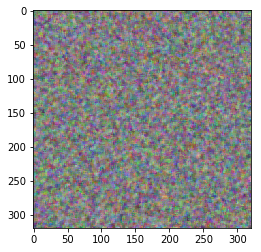

In [24]:
img.show_image(img.random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [25]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["hooks", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [26]:
class Synthesizer():
    def __init__(self, params):
        self.saver = img.Saver(params["save_mode"])
        self.example_feature_pyr = params["example_feature_pyr"]
        self.save_at = 1 if params["save_mode"] == "throughout" else 0
    
    def synthesize(self, params):
        if self.save_at == 0:
            self.save_at = params["iterations"]
        
        sample_texture = img.random_image(params["blur"], params["size"])
        optimizer = optim.LBFGS([sample_texture], lr=params["lr"])
        stepper = GradientStepper(optimizer, params["model"], sample_texture, self.example_feature_pyr, params["hooks"], params["scale"])
        
        self.saver.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                self.saver.save_image(torch.tensor(sample_texture, requires_grad=True), self.save_at)
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        self.save_at = 0
        return sample_texture, stepper.losses

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

xstd-normalized-mud-size400-layers4-blur4-scale_decay0-scale1000000-lr0.1
scale: 1000000
loss: 187370.203125
scale: 1000000
loss: 187365.453125
scale: 1000000
loss: 126364.75
scale: 1000000
loss: 115340.0625
scale: 1000000
loss: 101530.625
scale: 1000000
loss: 89934.0859375
scale: 1000000
loss: 79382.65625
scale: 1000000
loss: 70121.6484375
scale: 1000000
loss: 61897.34765625
scale: 1000000
loss: 54709.78515625
scale: 1000000
loss: 48353.6640625
scale: 1000000
loss: 42734.5390625
scale: 1000000
loss: 37890.44140625
scale: 1000000
loss: 33637.8125
scale: 1000000
loss: 29831.15234375
scale: 1000000
loss: 26513.3828125
scale: 1000000
loss: 23626.6328125
scale: 1000000
loss: 21084.271484375
scale: 1000000
loss: 18839.087890625
scale: 1000000
loss: 16863.205078125
tensor([0.5986, 0.3954, 0.3821, 0.1128], device='cuda:0')
scale: 1000000
loss: 15146.921875
scale: 1000000
loss: 13632.927734375
scale: 1000000
loss: 12289.2333984375
scale: 1000000


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss: 11124.4130859375
scale: 1000000
loss: 10088.62109375
scale: 1000000
loss: 9162.5986328125
scale: 1000000
loss: 8356.51953125
scale: 1000000
loss: 7653.0322265625
scale: 1000000
loss: 7024.78759765625
scale: 1000000
loss: 6464.0576171875
scale: 1000000
loss: 5975.02978515625
scale: 1000000
loss: 5531.7109375
scale: 1000000
loss: 5135.9775390625
scale: 1000000
loss: 4783.6015625
scale: 1000000
loss: 4469.37158203125
scale: 1000000
loss: 4186.177734375
scale: 1000000
loss: 3925.32958984375
scale: 1000000
loss: 3687.153076171875
scale: 1000000
loss: 3469.958251953125
scale: 1000000
loss: 3272.5205078125
tensor([0.1789, 0.1976, 0.1944, 0.1012], device='cuda:0')
scale: 1000000
loss: 3087.36279296875
scale: 1000000
loss: 2914.507080078125
scale: 1000000
loss: 2750.525634765625
scale: 1000000
loss: 2593.36474609375
scale: 1000000
loss: 2448.66064453125
scale: 1000000
loss: 2311.75927734375
scale: 1000000
loss: 2181.5888671875
scale: 1000000
loss: 2064.51953125
scale: 1000000
loss: 1954.6

tensor([ 0.0079,  0.0047,  0.0023, -0.0015], device='cuda:0')
scale: 1000000
loss: 100.05977630615234
scale: 1000000
loss: 99.1587905883789
scale: 1000000
loss: 98.18846893310547
scale: 1000000
loss: 97.21468353271484
scale: 1000000
loss: 96.21675872802734
scale: 1000000
loss: 95.18553161621094
scale: 1000000
loss: 94.2878646850586
scale: 1000000
loss: 93.43598175048828
scale: 1000000
loss: 92.65719604492188
scale: 1000000
loss: 91.84201049804688
scale: 1000000
loss: 91.04119110107422
scale: 1000000
loss: 90.2403335571289
scale: 1000000
loss: 89.36473846435547
scale: 1000000
loss: 88.53707122802734
scale: 1000000
loss: 87.69738006591797
scale: 1000000
loss: 86.92672729492188
scale: 1000000
loss: 86.18701934814453
scale: 1000000
loss: 85.431396484375
scale: 1000000
loss: 84.65000915527344
scale: 1000000
loss: 83.90238189697266
tensor([ 0.0035,  0.0020, -0.0007, -0.0039], device='cuda:0')
scale: 1000000
loss: 83.14939880371094
scale: 1000000
loss: 82.45916748046875
scale: 1000000
loss: 8

scale: 1000000
loss: 39.594093322753906
scale: 1000000
loss: 39.53034973144531
scale: 1000000
loss: 39.46728515625
scale: 1000000
loss: 39.390682220458984
tensor([-0.0010, -0.0008, -0.0006, -0.0004], device='cuda:0')
scale: 1000000
loss: 39.316654205322266
scale: 1000000
loss: 39.2489013671875
scale: 1000000
loss: 39.1861686706543
scale: 1000000
loss: 39.105831146240234
scale: 1000000
loss: 39.04287338256836
scale: 1000000
loss: 38.97484588623047
scale: 1000000
loss: 38.909244537353516
scale: 1000000
loss: 38.84074020385742
scale: 1000000
loss: 38.775970458984375
scale: 1000000
loss: 38.69588088989258
scale: 1000000
loss: 38.61417770385742
scale: 1000000
loss: 38.53738784790039
scale: 1000000
loss: 38.46691131591797
scale: 1000000
loss: 38.3881950378418
scale: 1000000
loss: 38.31079864501953
scale: 1000000
loss: 38.241947174072266
scale: 1000000
loss: 38.16687774658203
scale: 1000000
loss: 38.09475326538086
scale: 1000000
loss: 38.02587127685547
scale: 1000000
loss: 37.95652389526367
t

scale: 1000000
loss: 28.393878936767578
scale: 1000000
loss: 28.34906768798828
scale: 1000000
loss: 28.30445671081543
scale: 1000000
loss: 28.261180877685547
scale: 1000000
loss: 28.21774673461914
scale: 1000000
loss: 28.172460556030273
scale: 1000000
loss: 28.13007164001465
scale: 1000000
loss: 28.087520599365234
scale: 1000000
loss: 28.034353256225586
tensor([0.0011, 0.0019, 0.0019, 0.0020], device='cuda:0')
scale: 1000000
loss: 27.995391845703125
scale: 1000000
loss: 27.9561710357666
scale: 1000000
loss: 27.913196563720703
scale: 1000000
loss: 27.87627410888672
scale: 1000000
loss: 27.836597442626953
scale: 1000000
loss: 27.79315757751465
scale: 1000000
loss: 27.750431060791016
scale: 1000000
loss: 27.690279006958008
scale: 1000000
loss: 27.645381927490234
scale: 1000000
loss: 27.606708526611328
scale: 1000000
loss: 27.562623977661133
scale: 1000000
loss: 27.5212459564209
scale: 1000000
loss: 27.48138427734375
scale: 1000000
loss: 27.440654754638672
scale: 1000000
loss: 27.400939941

scale: 1000000
loss: 20.6009464263916
scale: 1000000
loss: 20.570823669433594
scale: 1000000
loss: 20.535179138183594
scale: 1000000
loss: 20.503761291503906
scale: 1000000
loss: 20.464492797851562
scale: 1000000
loss: 20.43436622619629
scale: 1000000
loss: 20.404438018798828
scale: 1000000
loss: 20.369924545288086
scale: 1000000
loss: 20.33342170715332
scale: 1000000
loss: 20.289051055908203
scale: 1000000
loss: 20.249650955200195
scale: 1000000
loss: 20.203428268432617
scale: 1000000
loss: 20.169769287109375
scale: 1000000
loss: 20.14089012145996
tensor([0.0027, 0.0032, 0.0026, 0.0020], device='cuda:0')
scale: 1000000
loss: 20.101152420043945
scale: 1000000
loss: 20.06210708618164
scale: 1000000
loss: 20.02189064025879
scale: 1000000
loss: 19.98455810546875
scale: 1000000
loss: 19.939762115478516
scale: 1000000
loss: 19.89599609375
scale: 1000000
loss: 19.859621047973633
scale: 1000000
loss: 19.823179244995117
scale: 1000000
loss: 19.78769874572754
scale: 1000000
loss: 19.74971389770

scale: 1000000
loss: 15.248190879821777
scale: 1000000
loss: 15.23521614074707
scale: 1000000
loss: 15.223082542419434
scale: 1000000
loss: 15.212332725524902
scale: 1000000
loss: 15.20003890991211
scale: 1000000
loss: 15.185948371887207
scale: 1000000
loss: 15.176507949829102
scale: 1000000
loss: 15.163098335266113
scale: 1000000
loss: 15.152525901794434
scale: 1000000
loss: 15.14203929901123
scale: 1000000
loss: 15.132217407226562
scale: 1000000
loss: 15.119407653808594
scale: 1000000
loss: 15.109061241149902
scale: 1000000
loss: 15.097432136535645
scale: 1000000
loss: 15.083369255065918
scale: 1000000
loss: 15.065921783447266
scale: 1000000
loss: 15.05219841003418
scale: 1000000
loss: 15.04042911529541
tensor([ 0.0001,  0.0003, -0.0004, -0.0005], device='cuda:0')
scale: 1000000
loss: 15.02933406829834
scale: 1000000
loss: 15.016457557678223
scale: 1000000
loss: 15.004114151000977
scale: 1000000
loss: 14.993134498596191
scale: 1000000
loss: 14.982276916503906
scale: 1000000
loss: 14.

scale: 1000000
loss: 13.354551315307617
scale: 1000000
loss: 13.347484588623047
scale: 1000000
loss: 13.340262413024902
scale: 1000000
loss: 13.333497047424316
scale: 1000000
loss: 13.326520919799805
scale: 1000000
loss: 13.319302558898926
tensor([0.0009, 0.0007, 0.0004, 0.0003], device='cuda:0')
scale: 1000000
loss: 13.311440467834473
scale: 1000000
loss: 13.305217742919922
scale: 1000000
loss: 13.297985076904297
scale: 1000000
loss: 13.292415618896484
scale: 1000000
loss: 13.285181999206543
scale: 1000000
loss: 13.276331901550293
scale: 1000000
loss: 13.270072937011719
scale: 1000000
loss: 13.264927864074707
scale: 1000000
loss: 13.258586883544922
scale: 1000000
loss: 13.251747131347656
scale: 1000000
loss: 13.245529174804688
scale: 1000000
loss: 13.239287376403809
scale: 1000000
loss: 13.233248710632324
scale: 1000000
loss: 13.22525691986084
scale: 1000000
loss: 13.21839427947998
scale: 1000000
loss: 13.212867736816406
scale: 1000000
loss: 13.206707000732422
scale: 1000000
loss: 13.

loss: 12.408069610595703
scale: 1000000
loss: 12.405596733093262
scale: 1000000
loss: 12.402899742126465
scale: 1000000
loss: 12.400839805603027
scale: 1000000
loss: 12.397940635681152
scale: 1000000
loss: 12.395953178405762
scale: 1000000
loss: 12.391258239746094
scale: 1000000
loss: 12.386969566345215
scale: 1000000
loss: 12.384432792663574
scale: 1000000
loss: 12.379936218261719
scale: 1000000
loss: 12.37709903717041
scale: 1000000
loss: 12.37437629699707
scale: 1000000
loss: 12.369681358337402
scale: 1000000
loss: 12.364553451538086
scale: 1000000
loss: 12.360688209533691
scale: 1000000
loss: 12.357444763183594
tensor([0.0004, 0.0003, 0.0004, 0.0004], device='cuda:0')
scale: 1000000
loss: 12.353568077087402
scale: 1000000
loss: 12.348261833190918
scale: 1000000
loss: 12.344245910644531
scale: 1000000
loss: 12.34062671661377
scale: 1000000
loss: 12.337104797363281
scale: 1000000
loss: 12.33395767211914
scale: 1000000
loss: 12.331425666809082
scale: 1000000
loss: 12.32947826385498
sc

scale: 1000000
loss: 11.890512466430664
scale: 1000000
loss: 11.88917350769043
scale: 1000000
loss: 11.887099266052246
scale: 1000000
loss: 11.885381698608398
tensor([-3.4801e-04, -3.4041e-04, -2.1185e-04, -1.4541e-05], device='cuda:0')
scale: 1000000
loss: 11.883650779724121
scale: 1000000
loss: 11.882352828979492
scale: 1000000
loss: 11.881136894226074
scale: 1000000
loss: 11.879528999328613
scale: 1000000
loss: 11.877021789550781
scale: 1000000
loss: 11.875587463378906
scale: 1000000
loss: 11.874004364013672
scale: 1000000
loss: 11.872478485107422
scale: 1000000
loss: 11.870644569396973
scale: 1000000
loss: 11.868629455566406
scale: 1000000
loss: 11.866981506347656
scale: 1000000
loss: 11.86498737335205
scale: 1000000
loss: 11.862007141113281
scale: 1000000
loss: 11.85943603515625
scale: 1000000
loss: 11.857240676879883
scale: 1000000
loss: 11.854666709899902
scale: 1000000
loss: 11.850410461425781
scale: 1000000
loss: 11.847671508789062
scale: 1000000
loss: 11.842581748962402
scale

scale: 1000000
loss: 11.485956192016602
scale: 1000000
loss: 11.483180046081543
scale: 1000000
loss: 11.480233192443848
scale: 1000000
loss: 11.477927207946777
scale: 1000000
loss: 11.473855972290039
scale: 1000000
loss: 11.470771789550781
scale: 1000000
loss: 11.468621253967285
scale: 1000000
loss: 11.466108322143555
scale: 1000000
loss: 11.463602066040039
scale: 1000000
loss: 11.461336135864258
scale: 1000000
loss: 11.457944869995117
scale: 1000000
loss: 11.456221580505371
scale: 1000000
loss: 11.454545974731445
scale: 1000000
loss: 11.452231407165527
tensor([0.0003, 0.0001, 0.0002, 0.0002], device='cuda:0')
scale: 1000000
loss: 11.450582504272461
scale: 1000000
loss: 11.448917388916016
scale: 1000000
loss: 11.446491241455078
scale: 1000000
loss: 11.444472312927246
scale: 1000000
loss: 11.442904472351074
scale: 1000000
loss: 11.441704750061035
scale: 1000000
loss: 11.440132141113281
scale: 1000000
loss: 11.438632011413574
scale: 1000000
loss: 11.436944961547852
scale: 1000000
loss: 1

scale: 1000000
loss: 11.123602867126465
tensor([-1.2657e-04, -5.3407e-05, -8.4954e-07, -1.5372e-04], device='cuda:0')
scale: 1000000
loss: 11.121930122375488
scale: 1000000
loss: 11.120192527770996
scale: 1000000
loss: 11.118639945983887
scale: 1000000
loss: 11.117676734924316
scale: 1000000
loss: 11.116270065307617
scale: 1000000
loss: 11.114911079406738
scale: 1000000
loss: 11.113327980041504
scale: 1000000
loss: 11.111534118652344
scale: 1000000
loss: 11.109807014465332
scale: 1000000
loss: 11.108441352844238
scale: 1000000
loss: 11.107056617736816
scale: 1000000
loss: 11.105481147766113
scale: 1000000
loss: 11.104025840759277
scale: 1000000
loss: 11.10254955291748
scale: 1000000
loss: 11.100997924804688
scale: 1000000
loss: 11.09957504272461
scale: 1000000
loss: 11.098258972167969
scale: 1000000
loss: 11.09703254699707
scale: 1000000
loss: 11.09575366973877
scale: 1000000
loss: 11.094415664672852
tensor([ 2.9409e-05,  4.4356e-05,  5.7140e-05, -7.5774e-05], device='cuda:0')
scale: 1

loss: 10.926056861877441
scale: 1000000
loss: 10.924870491027832
scale: 1000000
loss: 10.92386245727539
scale: 1000000
loss: 10.923551559448242
scale: 1000000
loss: 10.922268867492676
scale: 1000000
loss: 10.921414375305176
scale: 1000000
loss: 10.920632362365723
scale: 1000000
loss: 10.919791221618652
scale: 1000000
loss: 10.919049263000488
scale: 1000000
loss: 10.91861629486084
scale: 1000000
loss: 10.917719841003418
scale: 1000000
loss: 10.91676139831543
tensor([0.0007, 0.0006, 0.0005, 0.0002], device='cuda:0')
scale: 1000000
loss: 10.915919303894043
scale: 1000000
loss: 10.915257453918457
scale: 1000000
loss: 10.914572715759277
scale: 1000000
loss: 10.914105415344238
scale: 1000000
loss: 10.913463592529297
scale: 1000000
loss: 10.912946701049805
scale: 1000000
loss: 10.912184715270996
scale: 1000000
loss: 10.911712646484375
scale: 1000000
loss: 10.911158561706543
scale: 1000000
loss: 10.910660743713379
scale: 1000000
loss: 10.91008186340332
scale: 1000000
loss: 10.909586906433105
s

tensor([0.0006, 0.0006, 0.0005, 0.0002], device='cuda:0')
scale: 1000000
loss: 10.778080940246582
scale: 1000000
loss: 10.777410507202148
scale: 1000000
loss: 10.776881217956543
scale: 1000000
loss: 10.776162147521973
scale: 1000000
loss: 10.775396347045898
scale: 1000000
loss: 10.775087356567383
scale: 1000000
loss: 10.773759841918945
scale: 1000000
loss: 10.773163795471191
scale: 1000000
loss: 10.772439956665039
scale: 1000000
loss: 10.77184009552002
scale: 1000000
loss: 10.770758628845215
scale: 1000000
loss: 10.77013111114502
scale: 1000000
loss: 10.769182205200195
scale: 1000000
loss: 10.768592834472656
scale: 1000000
loss: 10.767497062683105
scale: 1000000
loss: 10.766777038574219
scale: 1000000
loss: 10.76619815826416
scale: 1000000
loss: 10.765774726867676
scale: 1000000
loss: 10.765226364135742
scale: 1000000
loss: 10.764598846435547
tensor([ 4.2553e-04,  3.6579e-04,  1.7072e-04, -5.0296e-05], device='cuda:0')
scale: 1000000
loss: 10.763845443725586
scale: 1000000
loss: 10.763

scale: 1000000
loss: 10.654353141784668
scale: 1000000
loss: 10.653804779052734
scale: 1000000
loss: 10.653091430664062
scale: 1000000
loss: 10.652519226074219
scale: 1000000
loss: 10.652046203613281
scale: 1000000
loss: 10.651374816894531
scale: 1000000
loss: 10.650617599487305
scale: 1000000
loss: 10.650412559509277
scale: 1000000
loss: 10.649603843688965
scale: 1000000
loss: 10.649166107177734
scale: 1000000
loss: 10.64831829071045
tensor([ 6.2195e-04,  3.6607e-04,  4.0625e-05, -5.4382e-05], device='cuda:0')
scale: 1000000
loss: 10.647648811340332
scale: 1000000
loss: 10.646995544433594
scale: 1000000
loss: 10.646570205688477
scale: 1000000
loss: 10.645759582519531
scale: 1000000
loss: 10.645173072814941
scale: 1000000
loss: 10.644387245178223
scale: 1000000
loss: 10.643954277038574
scale: 1000000
loss: 10.643512725830078
scale: 1000000
loss: 10.643011093139648
scale: 1000000
loss: 10.642552375793457
scale: 1000000
loss: 10.642175674438477
scale: 1000000
loss: 10.64150619506836
scal

tensor([ 2.2455e-04,  1.4334e-04, -8.0408e-05, -1.1761e-04], device='cuda:0')
scale: 1000000
loss: 10.564779281616211
scale: 1000000
loss: 10.564359664916992
scale: 1000000
loss: 10.56369686126709
scale: 1000000
loss: 10.563295364379883
scale: 1000000
loss: 10.563051223754883
scale: 1000000
loss: 10.562454223632812
scale: 1000000
loss: 10.562103271484375
scale: 1000000
loss: 10.561736106872559
scale: 1000000
loss: 10.561217308044434
scale: 1000000
loss: 10.560932159423828
scale: 1000000
loss: 10.560452461242676
scale: 1000000
loss: 10.560131072998047
scale: 1000000
loss: 10.559797286987305
scale: 1000000
loss: 10.5595703125
scale: 1000000
loss: 10.559045791625977
scale: 1000000
loss: 10.558807373046875
scale: 1000000
loss: 10.558307647705078
scale: 1000000
loss: 10.55777359008789
scale: 1000000
loss: 10.557292938232422
scale: 1000000
loss: 10.556890487670898
tensor([ 3.7853e-04,  1.5604e-04, -5.9396e-05, -1.2684e-04], device='cuda:0')
scale: 1000000
loss: 10.556589126586914
scale: 1000

scale: 1000000
loss: 10.485658645629883
scale: 1000000
loss: 10.485451698303223
scale: 1000000
loss: 10.484709739685059
scale: 1000000
loss: 10.48436164855957
scale: 1000000
loss: 10.483957290649414
scale: 1000000
loss: 10.483396530151367
scale: 1000000
loss: 10.482967376708984
scale: 1000000
loss: 10.482551574707031
scale: 1000000
loss: 10.482224464416504
scale: 1000000
loss: 10.481847763061523
scale: 1000000
loss: 10.48133659362793
tensor([6.0691e-04, 2.9504e-04, 7.6000e-05, 1.8551e-04], device='cuda:0')
scale: 1000000
loss: 10.480942726135254
scale: 1000000
loss: 10.480489730834961
scale: 1000000
loss: 10.480167388916016
scale: 1000000
loss: 10.479732513427734
scale: 1000000
loss: 10.479307174682617
scale: 1000000
loss: 10.478914260864258
scale: 1000000
loss: 10.478554725646973
scale: 1000000
loss: 10.478164672851562
scale: 1000000
loss: 10.477729797363281
scale: 1000000
loss: 10.47735595703125
scale: 1000000
loss: 10.476900100708008
scale: 1000000
loss: 10.476572036743164
scale: 10

tensor([7.2678e-04, 3.5659e-04, 9.9147e-05, 2.7725e-04], device='cuda:0')
scale: 1000000
loss: 10.418989181518555
scale: 1000000
loss: 10.418542861938477
scale: 1000000
loss: 10.418261528015137
scale: 1000000
loss: 10.418025970458984
scale: 1000000
loss: 10.417736053466797
scale: 1000000
loss: 10.417533874511719
scale: 1000000
loss: 10.417169570922852
scale: 1000000
loss: 10.416922569274902
scale: 1000000
loss: 10.41671371459961
scale: 1000000
loss: 10.416450500488281
scale: 1000000
loss: 10.416255950927734
scale: 1000000
loss: 10.41591739654541
scale: 1000000
loss: 10.415580749511719
scale: 1000000
loss: 10.415392875671387
scale: 1000000
loss: 10.41498851776123
scale: 1000000
loss: 10.414714813232422
scale: 1000000
loss: 10.414402961730957
scale: 1000000
loss: 10.414151191711426
scale: 1000000
loss: 10.413811683654785
scale: 1000000
loss: 10.413383483886719
tensor([6.0107e-04, 2.4366e-04, 1.0927e-06, 2.2019e-04], device='cuda:0')
scale: 1000000
loss: 10.413128852844238
scale: 1000000


scale: 1000000
loss: 10.357072830200195
scale: 1000000
loss: 10.356830596923828
scale: 1000000
loss: 10.356557846069336
scale: 1000000
loss: 10.356125831604004
scale: 1000000
loss: 10.355841636657715
scale: 1000000
loss: 10.355629920959473
scale: 1000000
loss: 10.355399131774902
scale: 1000000
loss: 10.355086326599121
scale: 1000000
loss: 10.35476303100586
scale: 1000000
loss: 10.35438060760498
tensor([0.0012, 0.0007, 0.0006, 0.0006], device='cuda:0')
scale: 1000000
loss: 10.354046821594238
scale: 1000000
loss: 10.353765487670898
scale: 1000000
loss: 10.353385925292969
scale: 1000000
loss: 10.35313606262207
scale: 1000000
loss: 10.352938652038574
scale: 1000000
loss: 10.35273265838623
scale: 1000000
loss: 10.352405548095703
scale: 1000000
loss: 10.351975440979004
scale: 1000000
loss: 10.351703643798828
scale: 1000000
loss: 10.351483345031738
scale: 1000000
loss: 10.35103702545166
scale: 1000000
loss: 10.35079574584961
scale: 1000000
loss: 10.35055160522461
scale: 1000000
loss: 10.35042

scale: 1000000
loss: 10.307223320007324
scale: 1000000
loss: 10.307074546813965
scale: 1000000
loss: 10.306819915771484
scale: 1000000
loss: 10.306588172912598
scale: 1000000
loss: 10.306425094604492
scale: 1000000
loss: 10.306161880493164
scale: 1000000
loss: 10.305943489074707
scale: 1000000
loss: 10.30571174621582
scale: 1000000
loss: 10.305431365966797
scale: 1000000
loss: 10.305184364318848
scale: 1000000
loss: 10.304905891418457
scale: 1000000
loss: 10.30458927154541
scale: 1000000
loss: 10.304316520690918
scale: 1000000
loss: 10.304131507873535
scale: 1000000
loss: 10.303620338439941
scale: 1000000
loss: 10.303400993347168
scale: 1000000
loss: 10.303277969360352
tensor([0.0009, 0.0005, 0.0004, 0.0003], device='cuda:0')
scale: 1000000
loss: 10.303028106689453
scale: 1000000
loss: 10.302742958068848
scale: 1000000
loss: 10.302532196044922
scale: 1000000
loss: 10.302410125732422
scale: 1000000
loss: 10.302265167236328
scale: 1000000
loss: 10.302022933959961
scale: 1000000
loss: 10.

scale: 1000000
loss: 10.26051139831543
scale: 1000000
loss: 10.260278701782227
scale: 1000000
loss: 10.260120391845703
scale: 1000000
loss: 10.259848594665527
tensor([0.0011, 0.0007, 0.0005, 0.0005], device='cuda:0')
scale: 1000000
loss: 10.259512901306152
scale: 1000000
loss: 10.259317398071289
scale: 1000000
loss: 10.259013175964355
scale: 1000000
loss: 10.258816719055176
scale: 1000000
loss: 10.258485794067383
scale: 1000000
loss: 10.258179664611816
scale: 1000000
loss: 10.257871627807617
scale: 1000000
loss: 10.257548332214355
scale: 1000000
loss: 10.257254600524902
scale: 1000000
loss: 10.257133483886719
scale: 1000000
loss: 10.25689697265625
scale: 1000000
loss: 10.256567001342773
scale: 1000000
loss: 10.25638198852539
scale: 1000000
loss: 10.256208419799805
scale: 1000000
loss: 10.255940437316895
scale: 1000000
loss: 10.255611419677734
scale: 1000000
loss: 10.255367279052734
scale: 1000000
loss: 10.255086898803711
scale: 1000000
loss: 10.25478458404541
scale: 1000000
loss: 10.25

scale: 1000000
loss: 10.2229642868042
scale: 1000000
loss: 10.222868919372559
scale: 1000000
loss: 10.222785949707031
scale: 1000000
loss: 10.222650527954102
scale: 1000000
loss: 10.222541809082031
scale: 1000000
loss: 10.222434997558594
scale: 1000000
loss: 10.222309112548828
scale: 1000000
loss: 10.222168922424316
scale: 1000000
loss: 10.222054481506348
scale: 1000000
loss: 10.22185230255127
scale: 1000000
loss: 10.221657752990723
tensor([0.0006, 0.0003, 0.0001, 0.0001], device='cuda:0')
scale: 1000000
loss: 10.221481323242188
scale: 1000000
loss: 10.221295356750488
scale: 1000000
loss: 10.221186637878418
scale: 1000000
loss: 10.2210054397583
scale: 1000000
loss: 10.220810890197754
scale: 1000000
loss: 10.220675468444824
scale: 1000000
loss: 10.220458030700684
scale: 1000000
loss: 10.220379829406738
scale: 1000000
loss: 10.22016429901123
scale: 1000000
loss: 10.219986915588379
scale: 1000000
loss: 10.219799995422363
scale: 1000000
loss: 10.219563484191895
scale: 1000000
loss: 10.2194

loss: 10.187253952026367
scale: 1000000
loss: 10.186957359313965
scale: 1000000
loss: 10.186779022216797
scale: 1000000
loss: 10.18660831451416
scale: 1000000
loss: 10.186382293701172
scale: 1000000
loss: 10.185969352722168
scale: 1000000
loss: 10.185754776000977
scale: 1000000
loss: 10.185504913330078
scale: 1000000
loss: 10.185218811035156
scale: 1000000
loss: 10.18498706817627
scale: 1000000
loss: 10.184794425964355
scale: 1000000
loss: 10.18450927734375
scale: 1000000
loss: 10.184267044067383
scale: 1000000
loss: 10.184078216552734
scale: 1000000
loss: 10.183890342712402
scale: 1000000
loss: 10.183523178100586
scale: 1000000
loss: 10.183361053466797
scale: 1000000
loss: 10.183160781860352
tensor([0.0010, 0.0005, 0.0004, 0.0004], device='cuda:0')
scale: 1000000
loss: 10.182929992675781
scale: 1000000
loss: 10.18278980255127
scale: 1000000
loss: 10.182583808898926
scale: 1000000
loss: 10.182304382324219
scale: 1000000
loss: 10.182010650634766
scale: 1000000
loss: 10.181742668151855
s

loss: 10.144742965698242
scale: 1000000
loss: 10.14460277557373
scale: 1000000
loss: 10.14442253112793
scale: 1000000
loss: 10.144270896911621
scale: 1000000
loss: 10.144108772277832
tensor([0.0007, 0.0003, 0.0002, 0.0002], device='cuda:0')
scale: 1000000
loss: 10.143997192382812
scale: 1000000
loss: 10.143791198730469
scale: 1000000
loss: 10.14369010925293
scale: 1000000
loss: 10.143434524536133
scale: 1000000
loss: 10.143274307250977
scale: 1000000
loss: 10.143088340759277
scale: 1000000
loss: 10.142901420593262
scale: 1000000
loss: 10.142724990844727
scale: 1000000
loss: 10.14256763458252
scale: 1000000
loss: 10.142494201660156
scale: 1000000
loss: 10.142355918884277
scale: 1000000
loss: 10.142266273498535
scale: 1000000
loss: 10.141951560974121
scale: 1000000
loss: 10.141815185546875
scale: 1000000
loss: 10.141592025756836
scale: 1000000
loss: 10.141321182250977
scale: 1000000
loss: 10.141118049621582
scale: 1000000
loss: 10.140730857849121
scale: 1000000
loss: 10.140480041503906
s

scale: 1000000
loss: 10.111498832702637
scale: 1000000
loss: 10.111297607421875
scale: 1000000
loss: 10.111104965209961
scale: 1000000
loss: 10.110915184020996
scale: 1000000
loss: 10.110754013061523
scale: 1000000
loss: 10.110627174377441
scale: 1000000
loss: 10.110401153564453
scale: 1000000
loss: 10.110234260559082
scale: 1000000
loss: 10.110068321228027
scale: 1000000
loss: 10.109904289245605
scale: 1000000
loss: 10.109715461730957
scale: 1000000
loss: 10.109477043151855
scale: 1000000
loss: 10.109297752380371
scale: 1000000
loss: 10.109111785888672
tensor([5.0795e-04, 1.4559e-04, 2.4459e-05, 6.2704e-05], device='cuda:0')
scale: 1000000
loss: 10.108845710754395
scale: 1000000
loss: 10.108668327331543
scale: 1000000
loss: 10.10843563079834
scale: 1000000
loss: 10.108243942260742
scale: 1000000
loss: 10.10816478729248
scale: 1000000
loss: 10.107988357543945
scale: 1000000
loss: 10.107818603515625
scale: 1000000
loss: 10.107625961303711
scale: 1000000
loss: 10.107442855834961
scale: 1

loss: 10.083661079406738
scale: 1000000
loss: 10.083588600158691
scale: 1000000
loss: 10.08343505859375
tensor([0.0005, 0.0001, 0.0001, 0.0002], device='cuda:0')
scale: 1000000
loss: 10.0833158493042
scale: 1000000
loss: 10.083218574523926
scale: 1000000
loss: 10.083064079284668
scale: 1000000
loss: 10.082951545715332
scale: 1000000
loss: 10.082870483398438
scale: 1000000
loss: 10.082716941833496
scale: 1000000
loss: 10.082539558410645
scale: 1000000
loss: 10.08243465423584
scale: 1000000
loss: 10.08226203918457
scale: 1000000
loss: 10.08210563659668
scale: 1000000
loss: 10.081941604614258
scale: 1000000
loss: 10.081777572631836
scale: 1000000
loss: 10.081646919250488
scale: 1000000
loss: 10.0814790725708
scale: 1000000
loss: 10.08128833770752
scale: 1000000
loss: 10.081157684326172
scale: 1000000
loss: 10.080985069274902
scale: 1000000
loss: 10.080911636352539
scale: 1000000
loss: 10.080774307250977
scale: 1000000
loss: 10.080665588378906
tensor([0.0007, 0.0003, 0.0003, 0.0003], devic

scale: 1000000
loss: 10.061667442321777
scale: 1000000
loss: 10.061539649963379
scale: 1000000
loss: 10.061441421508789
scale: 1000000
loss: 10.061327934265137
scale: 1000000
loss: 10.061200141906738
scale: 1000000
loss: 10.061107635498047
scale: 1000000
loss: 10.060980796813965
scale: 1000000
loss: 10.060888290405273
scale: 1000000
loss: 10.060774803161621
scale: 1000000
loss: 10.06067180633545
tensor([0.0005, 0.0002, 0.0002, 0.0001], device='cuda:0')
scale: 1000000
loss: 10.060583114624023
scale: 1000000
loss: 10.060408592224121
scale: 1000000
loss: 10.060274124145508
scale: 1000000
loss: 10.060230255126953
scale: 1000000
loss: 10.060086250305176
scale: 1000000
loss: 10.060001373291016
scale: 1000000
loss: 10.059931755065918
scale: 1000000
loss: 10.059883117675781
scale: 1000000
loss: 10.059739112854004
scale: 1000000
loss: 10.059624671936035
scale: 1000000
loss: 10.059530258178711
scale: 1000000
loss: 10.059444427490234
scale: 1000000
loss: 10.059318542480469
scale: 1000000
loss: 10

loss: 10.040545463562012
scale: 1000000
loss: 10.040450096130371
scale: 1000000
loss: 10.040419578552246
scale: 1000000
loss: 10.040311813354492
scale: 1000000
loss: 10.04024600982666
scale: 1000000
loss: 10.040144920349121
scale: 1000000
loss: 10.040037155151367
scale: 1000000
loss: 10.039986610412598
scale: 1000000
loss: 10.039896011352539
scale: 1000000
loss: 10.039815902709961
scale: 1000000
loss: 10.039728164672852
scale: 1000000
loss: 10.039653778076172
scale: 1000000
loss: 10.039589881896973
scale: 1000000
loss: 10.03953742980957
scale: 1000000
loss: 10.039460182189941
scale: 1000000
loss: 10.039399147033691
scale: 1000000
loss: 10.039371490478516
scale: 1000000
loss: 10.039278984069824
scale: 1000000
loss: 10.039246559143066
tensor([0.0006, 0.0003, 0.0002, 0.0001], device='cuda:0')
scale: 1000000
loss: 10.039156913757324
scale: 1000000
loss: 10.039118766784668
scale: 1000000
loss: 10.038991928100586
scale: 1000000
loss: 10.038944244384766
scale: 1000000
loss: 10.038836479187012

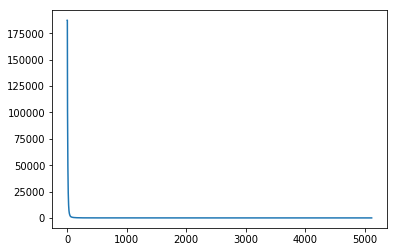

In [27]:
importlib.reload(stats)
params = {
    "x": "std-normalized",
    "name": img_name,
    "size": 400,
    "layers": 4,
    "iterations": 256,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "hooks": hooks,
    "lr": 0.1,
}

meta_params = {
    "save_mode": "throughout" ,
    "example_feature_pyr": example_feature_pyr,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [1000000]:
    for lr in [0.1]:
        for blur in [4]:
            params["lr"] = lr
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            _, losses = syn.synthesize(params)
            plt.figure()
            plt.plot(losses)